## NIFTY 50(Market Index) Closing Price Forecasting Using Time Series Analysis with ARIMA Model

Stock price prediction is a crucial aspect of financial markets, attracting investors, analysts, and researchers alike. Among the various indices in the Indian stock market, the Nifty 50 is one of the most prominent benchmarks, representing the top 50 companies listed on the National Stock Exchange (NSE). Predicting the movement of Nifty 50 stock prices can provide valuable insights for making informed investment decisions, managing risk, and maximizing returns.

Time series analysis is a powerful statistical tool widely used for predicting stock prices due to its ability to capture patterns, trends, and seasonality in historical data. Time series models, such as ARIMA (AutoRegressive Integrated Moving Average), SARIMA (Seasonal ARIMA), and more advanced approaches like LSTM (Long Short-Term Memory) neural networks, are commonly employed to forecast stock prices.

These models analyze past price movements, trading volumes, and other relevant financial indicators to make predictions about future prices. They are particularly effective in identifying short-term trends and making forecasts based on historical data patterns. The predictive accuracy of these models depends on various factors, including the choice of model, parameter tuning, and the quality of input data.

In this study, we aim to utilize time series models to forecast the Nifty 50 stock prices, focusing on evaluating the model's performance and accuracy. By leveraging these predictive techniques, stakeholders can gain a deeper understanding of market dynamics and make data-driven decisions in a volatile financial environment.

### What is ARIMA Model?

The Autoregressive Integrated Moving Average (ARIMA) model is a powerful predictive tool used primarily in time series analysis. This model is crucial for transforming non-stationary data into stationary data, a necessary step for effective forecasting. ARIMA is renowned for its application in predicting future prices based on historical data, making it highly valued in financial sectors such as banking and economics. By using regression on past values, ARIMA helps to accurately forecast short-term movements in stock prices and stock returns, demonstrating its efficacy as a predictive model.



In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
stock_data = pd.read_csv(r"C:\Users\satyaki basak\Downloads\Nifty 50 data.csv", 
    sep=',', 
    index_col='Date', 
    parse_dates=['Date'], 
    date_parser=lambda dates: pd.to_datetime(dates, format='%d-%m-%Y')  ).fillna(0)

In [6]:
stock_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-09-01,4356.100098,4558.000000,3715.050049,3921.199951,3921.199951,0.0
2008-10-01,3921.850098,4000.500000,2252.750000,2885.600098,2885.600098,0.0
2008-11-01,2885.399902,3240.550049,2502.899902,2755.100098,2755.100098,0.0
2008-12-01,2755.149902,3110.449951,2570.699951,2959.149902,2959.149902,0.0
2009-01-01,2963.300049,3147.199951,2661.649902,2874.800049,2874.800049,0.0


#### Visualising Nifty Closing Price

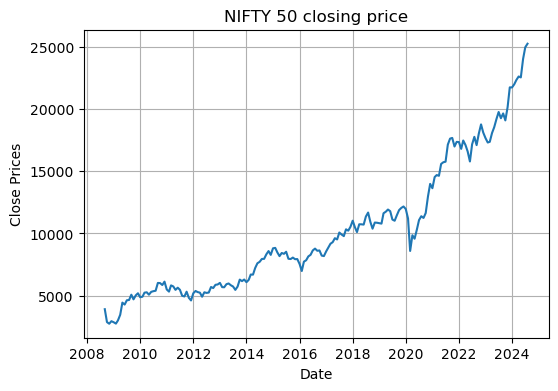

In [8]:
#plot close price
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NIFTY 50 closing price')
plt.show()

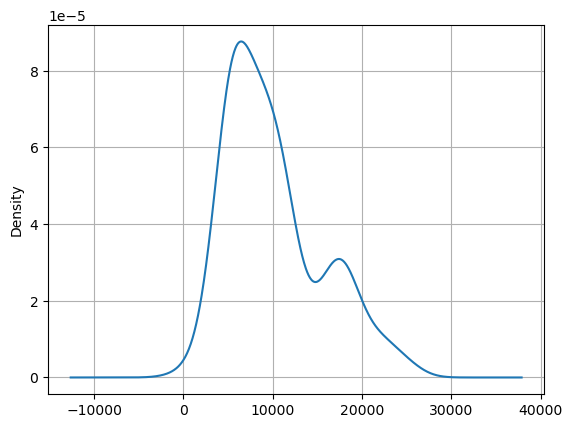

<Figure size 600x400 with 0 Axes>

In [10]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')
plt.grid(True)
plt.figure(figsize=(6,4))
plt.show()

#### Test for Stationarity

A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise. The following are the components’ definitions:

* The average value in the series is called the level.
* The increasing or falling value in the series is referred to as the trend.
* Seasonality is the series’ recurring short-term cycle.
* The random variance in the series is referred to as noise.
Because time series analysis only works with stationary data, we must first determine whether a series is stationary.

### ADF(Augmented Dickey-Fuller) Test

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

* Null Hypothesis: The series has a unit root (value of a =1)
* Alternate Hypothesis: The series has no unit root. If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

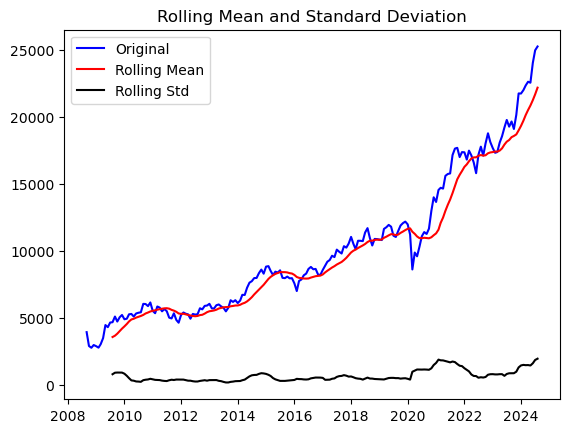

Results of dickey fuller test
Test Statistics                 -1.437697
p-value                          0.564076
No. of lags used                 3.000000
Number of observations used    189.000000
critical value (1%)             -3.465431
critical value (5%)             -2.876957
critical value (10%)            -2.574988
dtype: float64


In [11]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

#### Eliminate Trend and Seasonality

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

In [16]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
from statsmodels.tsa.seasonal import seasonal_decompose

# Use 'period' instead of 'freq'
result = seasonal_decompose(df_close, model='additive', period=30)

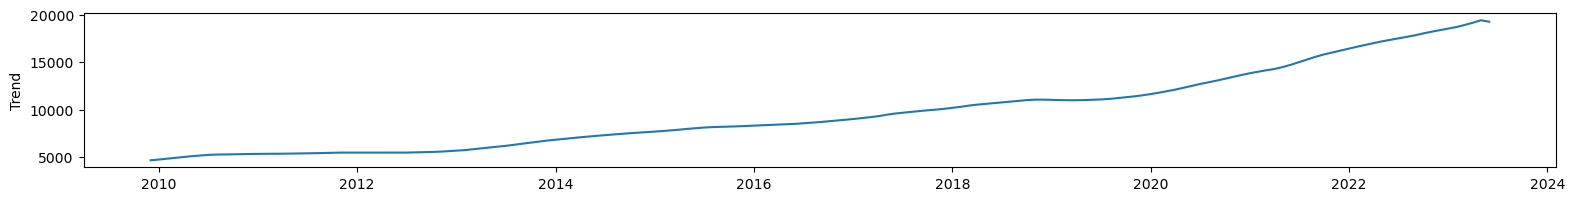

In [28]:
plt.figure(figsize=(19,2))
plt.ylabel('Trend')
plt.plot(result.trend)


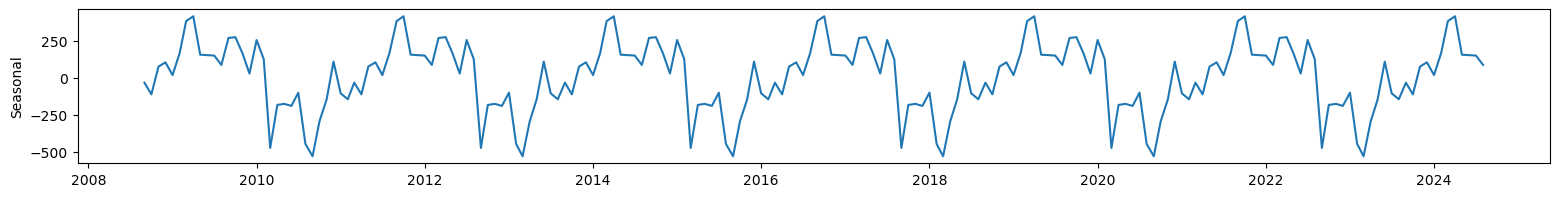

In [29]:
plt.figure(figsize=(19,2))
plt.ylabel('Seasonal')
plt.plot(result.seasonal)

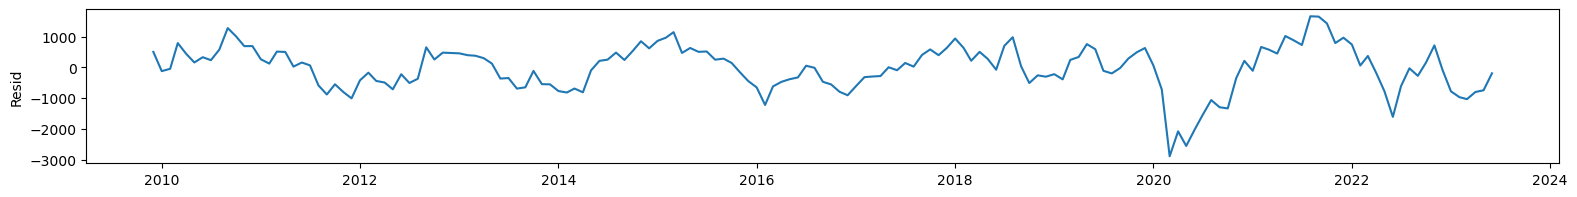

In [30]:
plt.figure(figsize=(19,2))
plt.ylabel('Resid')
plt.plot(result.resid)

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


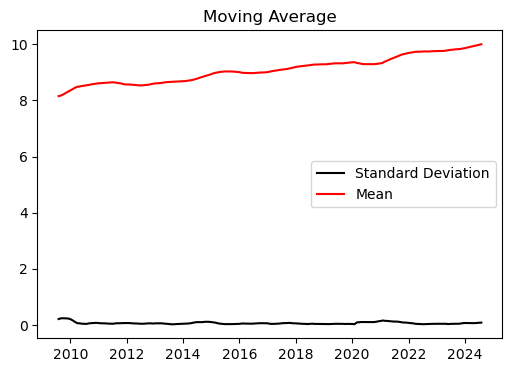

In [32]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 6,4
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

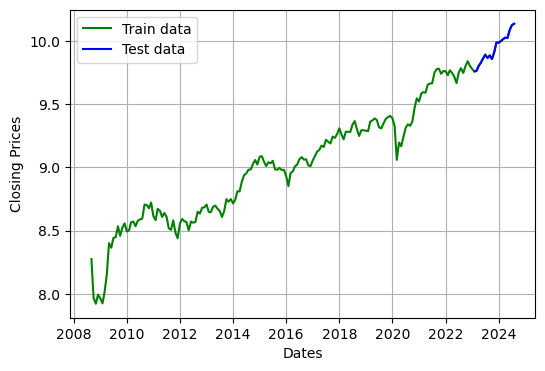

In [34]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

It’s time to choose the ARIMA model’s p,q, and d parameters. We chose the values of p,d, and q last time by looking at the ACF and PACF charts, but this time we’ll utilize Auto ARIMA to find the best parameters without looking at the ACF and PACF graphs.

To clarify, the p parameter in the ARIMA model denotes the number of lag observations included in the model, reflecting the autoregressive part that predicts future values based on past values. The d parameter represents the degree of differencing required to make the data stationary, addressing trends or seasonal effects by subtracting previous observations from current ones. Lastly, q indicates the size of the moving average window, which incorporates the dependency of an observation on a residual error from a moving average model applied to lagged observations. Understanding these parameters is crucial as they directly impact the model’s ability to capture the underlying patterns in the time series data.

#### Auto ARIMA: Find the Best Parameters

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-499.466, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-497.694, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-497.733, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-495.238, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-495.977, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.723 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  170
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 251.733
Date:                Mon, 02 Sep 2024   AIC                           -499.466
Time:                        19:25:41   BIC                           -493.206
Sample:                    12-01-2008   HQIC                          -496.926
                         - 01-01-2023                                       

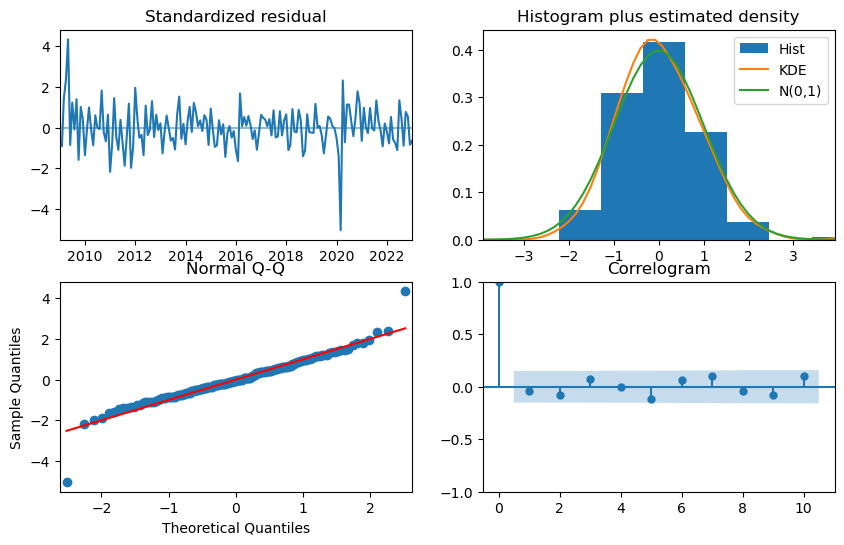

In [39]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,6))
plt.show()

So, how should the plot diagnostics be interpreted?

* Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

* Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

* Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

* Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

### Modeling and Forecasting

Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.

In [37]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  170
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 248.892
Date:                Mon, 02 Sep 2024   AIC                           -489.783
Time:                        19:20:11   BIC                           -477.264
Sample:                    12-01-2008   HQIC                          -484.703
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3949      1.412     -0.280      0.780      -3.162       2.372
ma.L1          0.4030      1.399      0.288      0.773      -2.340       3.146
ma.L2         -0.0444      0.076     -0.583      0.5

In [53]:
# Forecast
fc = fitted.forecast(20, alpha=0.05)  # 95% conf
fe = fitted.forecast(20, alpha=0.05)
conf = fitted.forecast(20, alpha=0.05)

In [54]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf, index=test_data.index)
upper_series = pd.Series(conf, index=test_data.index)

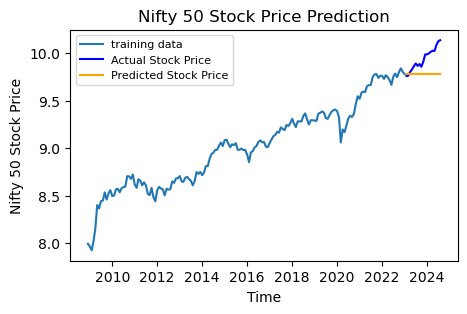

In [55]:
# Plot
plt.figure(figsize=(5,3), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Nifty 50 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nifty 50 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluate Model Performance


Our model played great, as you can see. Let’s take a look at some of the most common accuracy metrics for evaluating forecast results:

In [60]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert to numpy arrays if not already
test_data = np.array(test_data)
fc = np.array(fc)

# Check for NaN or inf values and remove or replace them
test_data = test_data[np.isfinite(test_data)]
fc = fc[np.isfinite(fc)]

# Check if lengths match after filtering
if len(fc) > len(test_data):
    fc = fc[:len(test_data)]
elif len(fc) < len(test_data):
    test_data = test_data[:len(fc)]

# Recalculate the metrics after filtering
mse = mean_squared_error(test_data, fc)
print('MSE:', mse)
mae = mean_absolute_error(test_data, fc)
print('MAE:', mae)
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE:',rmse)
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: ',mape

MSE: 0.03700788207249065
MAE: 0.16011163739651219
RMSE: 0.19237432799750245
MAPE:  0.01599393052753116


#### Interpreting the Metrices

* Mean Squared Error (MSE: 0.0370): This measures the average squared difference between the predicted and actual values. A lower MSE indicates that the model predictions are closer to the actual values, suggesting good model performance. In this case, the MSE value is relatively low, indicating that the model has performed well in minimizing large errors.

* Mean Absolute Error (MAE: 0.1601): MAE represents the average magnitude of errors in the predictions, without considering their direction. An MAE of 0.1601 suggests that, on average, the model’s predictions deviate from the actual values by around 0.16 units, which demonstrates a reasonable level of accuracy for stock price predictions.

* Root Mean Squared Error (RMSE: 0.1924): RMSE is similar to MSE but provides an error metric in the same units as the data, making it more interpretable. An RMSE of 0.1924 indicates that the typical prediction error is about 0.19 units, reinforcing the model's decent performance in forecasting stock prices.

* Mean Absolute Percentage Error (MAPE: 0.01599 or 1.599%): MAPE measures the accuracy of the model as a percentage. A MAPE of 1.599% is quite low, signifying that the model's predictions are very close to the actual values, with only around 1.6% average error. This level of accuracy is excellent, especially in the short run, suggesting that the model can reliably capture the stock price trends.

Overall Interpretation: The combination of low MSE, MAE, RMSE, and MAPE values indicates that the time series model is effective in predicting Nifty 50 stock prices with high accuracy in the short term. These metrics suggest that the model's forecast errors are small and manageable, making it a reliable tool for investment decision-making and risk assessment.

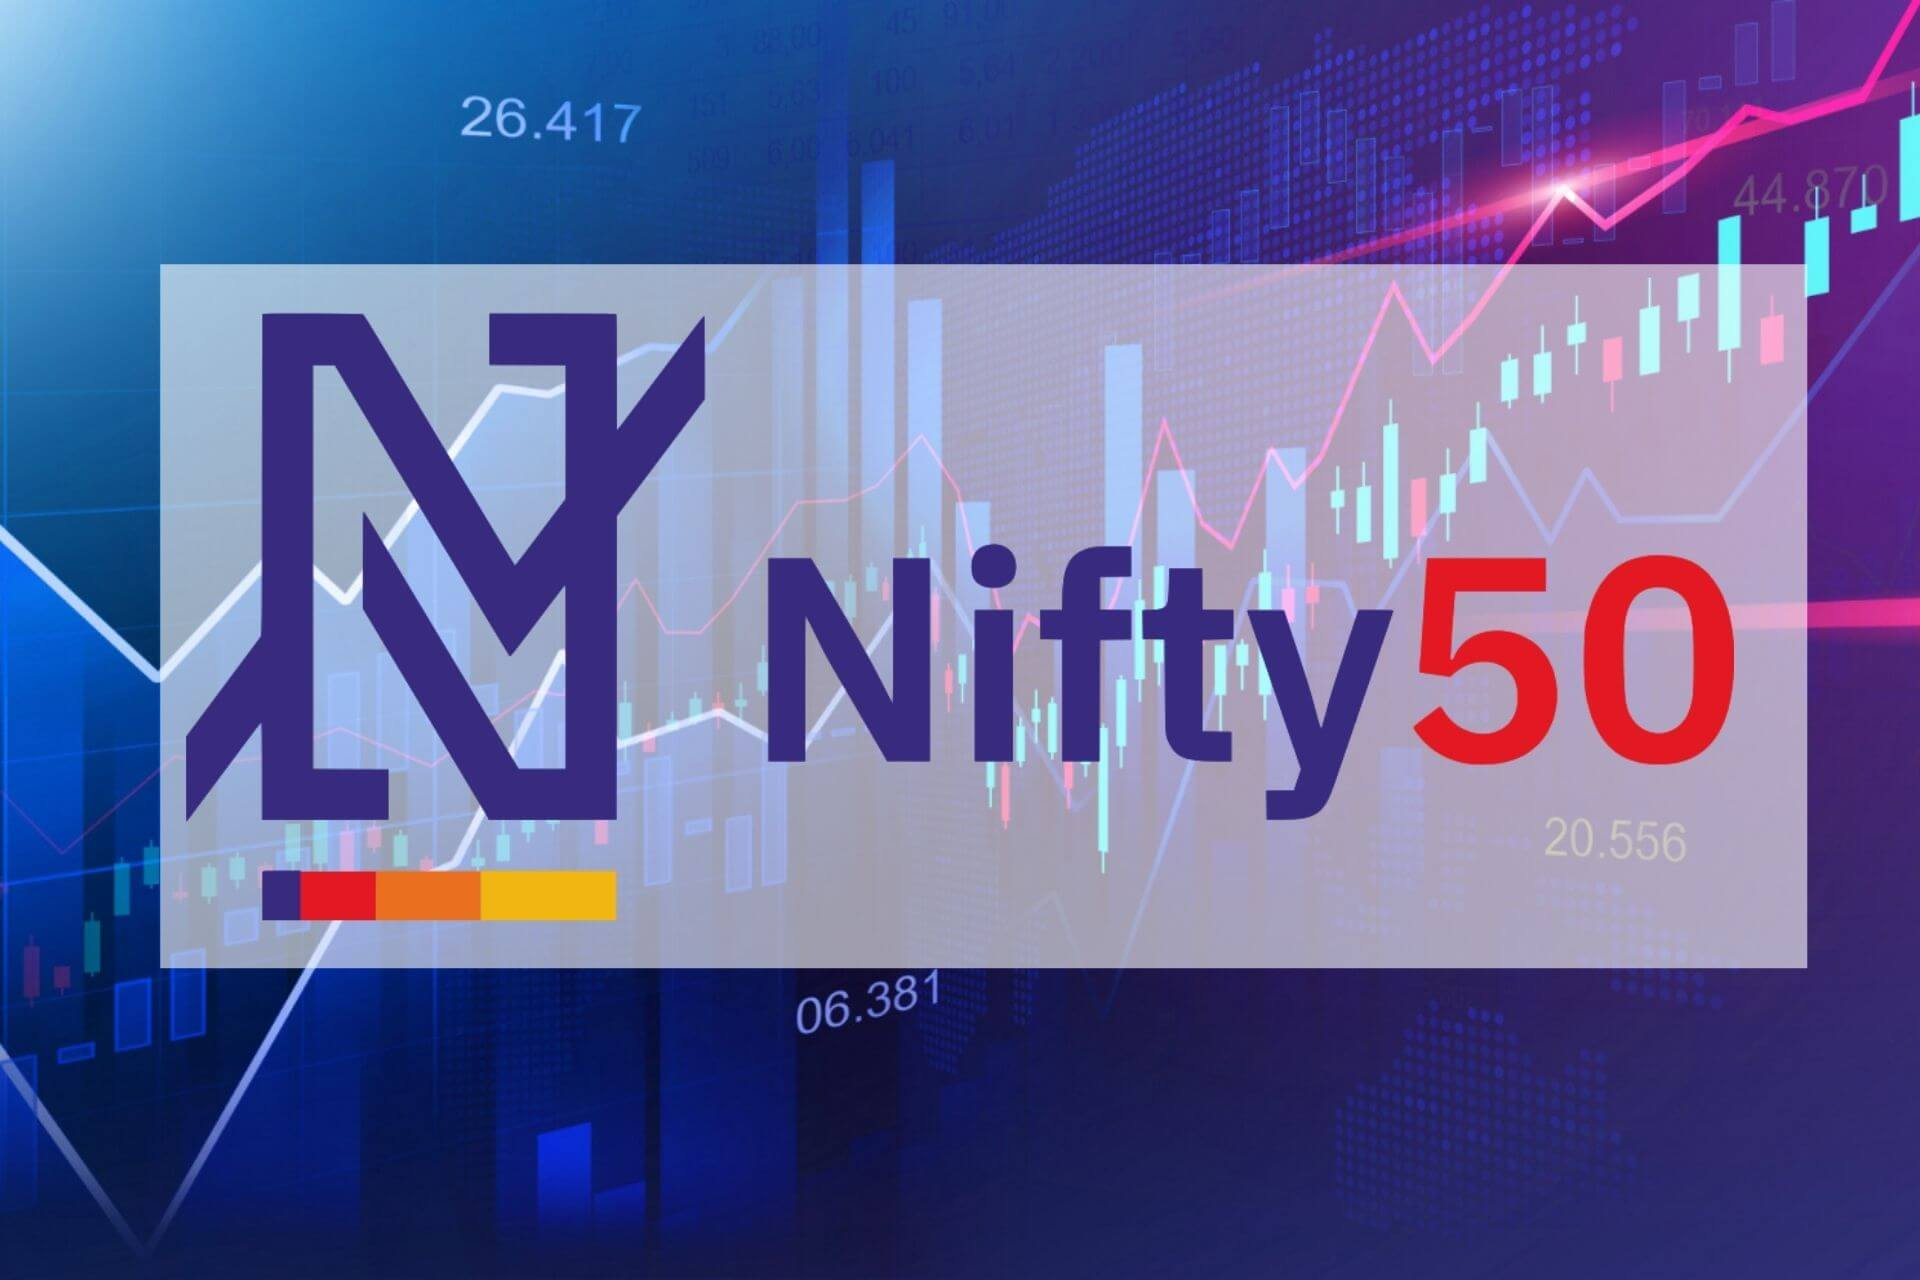
